HW3 <br>
Question 1 <br>
Mahdi Koloushani <br>
401300066

In [1]:
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import datetime
import keras_cv
from keras.callbacks import ModelCheckpoint
import seaborn as sn
%load_ext tensorboard



C:\Anaconda\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.


## Display Dataset

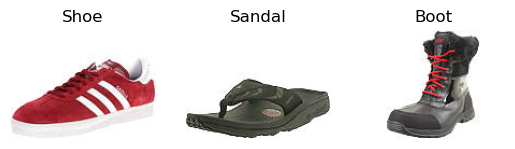

In [2]:
img_shoes = keras.utils.load_img('./Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (200).jpg')
img_sandals = keras.utils.load_img('./Shoe vs Sandal vs Boot Dataset/Sandal/Sandal (200).jpg')
img_boot = keras.utils.load_img('./Shoe vs Sandal vs Boot Dataset/Boot/boot (200).jpg')

img_shoes = keras.utils.img_to_array(img_shoes)/255
img_sandals = keras.utils.img_to_array(img_sandals)/255
img_boot = keras.utils.img_to_array(img_boot)/255

fig, ax = plt.subplots(1,3)
ax[0].imshow(img_shoes)
ax[0].axis('off')
ax[0].title.set_text('Shoe')
ax[1].imshow(img_sandals)
ax[1].axis('off')
ax[1].title.set_text('Sandal')
ax[2].imshow(img_boot)
ax[2].axis('off')
ax[2].title.set_text('Boot')

## Data loading and Splitting

In [4]:
batch_size = 32
split_ratio = 0.7
Data_path   ='./Shoe vs Sandal vs Boot Dataset/'
Data = keras.utils.image_dataset_from_directory(Data_path,labels = "inferred", shuffle=True,batch_size=batch_size,image_size=[48,48], label_mode= 'categorical' )
train_size = int(split_ratio * len(Data))
train_dataset = Data.take(train_size)
test_dataset = Data.skip(train_size)

#Split train dataset to train and validation datasets
val_ratio = 0.2
train_size = int(val_ratio * len(Data))
temp = train_dataset
valid_dataset = temp.skip(train_size)
train_dataset = temp.take(train_size)

Found 15000 files belonging to 3 classes.


In [5]:
lr = 1e-3 # learning rate
epochs = 30

# MLP

### Design MLP Structure

In [7]:
model_MLP = keras.models.Sequential()
model_MLP.add(keras.layers.Rescaling(1. / 255))
model_MLP.add(keras.layers.Flatten())
model_MLP.add(keras.layers.Dense(250, activation='relu'))
model_MLP.add(keras.layers.Dense(150, activation='relu'))
model_MLP.add(keras.layers.Dense(100, activation='relu'))
model_MLP.add(keras.layers.Dense(80, activation='relu'))
model_MLP.add(keras.layers.Dropout(0.2))
model_MLP.add(keras.layers.Dense(50, activation='relu'))
model_MLP.add(keras.layers.Dense(20, activation='relu'))
model_MLP.add(keras.layers.Dense(3, activation='softmax'))


### Train the MLP

In [8]:
metrics = ['categorical_accuracy', 'Recall', 'Precision']
model_MLP.compile(optimizer = keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics = metrics)

log_dir = "log_MLP1/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

filepath_MLP = 'My_Best_MLP_Model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath_MLP, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model_MLP.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, callbacks=[tensorboard_callback, checkpoint])

Epoch 1/30
91/93 [============================>.] - ETA: 0s - loss: 0.9365 - categorical_accuracy: 0.5354 - recall: 0.4238 - precision: 0.5857
Epoch 1: val_loss improved from inf to 0.62529, saving model to My_Best_MLP_Model.hdf5
93/93 [==============================] - 9s 78ms/step - loss: 0.9312 - categorical_accuracy: 0.5397 - recall: 0.4288 - precision: 0.5896 - val_loss: 0.6253 - val_categorical_accuracy: 0.7545 - val_recall: 0.7241 - val_precision: 0.7859
Epoch 2/30
91/93 [============================>.] - ETA: 0s - loss: 0.5729 - categorical_accuracy: 0.7613 - recall: 0.7280 - precision: 0.7826
Epoch 2: val_loss improved from 0.62529 to 0.48488, saving model to My_Best_MLP_Model.hdf5
93/93 [==============================] - 7s 78ms/step - loss: 0.5721 - categorical_accuracy: 0.7604 - recall: 0.7272 - precision: 0.7809 - val_loss: 0.4849 - val_categorical_accuracy: 0.8112 - val_recall: 0.7989 - val_precision: 0.8227
Epoch 3/30
92/93 [============================>.] - ETA: 0s - lo

### Metrics for Trained MLP Network on Test Dataset

In [9]:
model_MLP = keras.models.load_model(filepath_MLP)
score = model_MLP.evaluate(test_dataset,verbose=0)
print("For Test Dataset, we have:")
print(f"Loss: {score[0]}")
print(f"Accuracy: {score[1]}")
print(f"Recall: {score[2]}")
print(f"Precision: {score[3]}")

For Test Dataset, we have:
Loss: 0.26116251945495605
Accuracy: 0.9080817103385925
Recall: 0.9034191966056824
Precision: 0.9123318195343018


### Confusion Matrix

[[1408.   40.   24.]
 [  48. 1355.   88.]
 [  60.  156. 1325.]]


<AxesSubplot:>

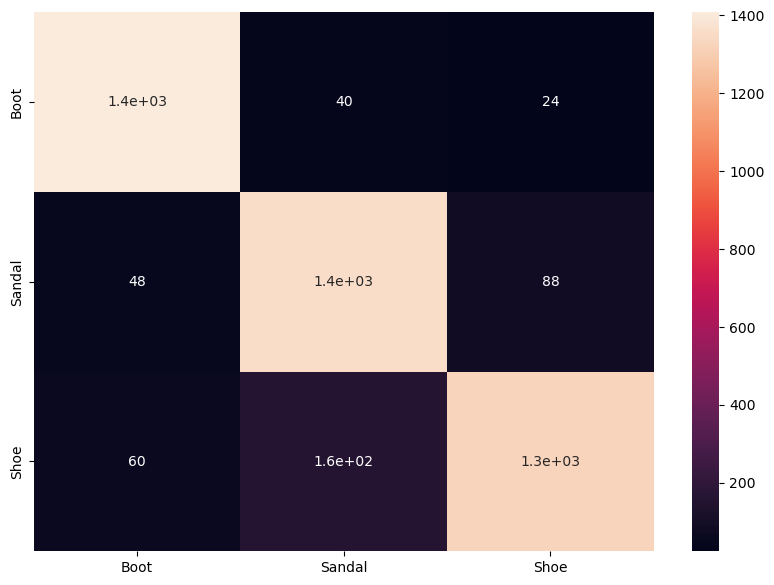

In [10]:
cm_MLP = np.zeros((3,3))
for images, labels in test_dataset.take(-1):
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    y_pred = model_MLP.predict(numpy_images,verbose = 0)
    pred = y_pred.argmax(axis=1)
    true = numpy_labels.argmax(axis=1)
    cm_MLP += confusion_matrix(true, pred)
print(cm_MLP)

df_cm = pd.DataFrame(cm_MLP, index = ["Boot", "Sandal", "Shoe"],
                  columns = ["Boot", "Sandal", "Shoe"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

### Network's Parameters

In [11]:
model_MLP.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 48, 48, 3)         0         
                                                                 
 flatten (Flatten)           (None, 6912)              0         
                                                                 
 dense (Dense)               (None, 250)               1728250   
                                                                 
 dense_1 (Dense)             (None, 150)               37650     
                                                                 
 dense_2 (Dense)             (None, 100)               15100     
                                                                 
 dense_3 (Dense)             (None, 80)                8080      
                                                                 
 dropout (Dropout)           (None, 80)                0

### Tensorboard

In [12]:
%tensorboard --logdir log_MLP1/fit

# CNN

### Design Network Structure

In [32]:
model_CNN=keras.models.Sequential()
model_CNN.add(keras.layers.Rescaling(1. / 255))
model_CNN.add(keras.layers.Conv2D(32,(3,3), activation='relu'))
model_CNN.add(keras.layers.Dropout(0.2))
model_CNN.add(keras.layers.MaxPooling2D(2,2))
model_CNN.add(keras.layers.Conv2D(32,(3,3), activation='relu'))
model_CNN.add(keras.layers.Conv2D(256,(3,3), activation='relu'))
model_CNN.add(keras.layers.Dropout(0.2))
model_CNN.add(keras.layers.MaxPooling2D(2,2))
model_CNN.add(keras.layers.Conv2D(256,(5,5), activation='relu'))
model_CNN.add(keras.layers.MaxPooling2D(2,2))
model_CNN.add(keras.layers.Flatten())
model_CNN.add(keras.layers.Dense(64, activation='relu'))
model_CNN.add(keras.layers.Dense(3, activation='softmax'))

### Train CNN

In [33]:
metrics = ['categorical_accuracy', 'Recall', 'Precision']
model_CNN.compile(optimizer = keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics = metrics)

log_dir = "log_CNN/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)

filepath_CNN = 'My_Best_CNN1_Model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath_CNN, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model_CNN.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, callbacks=[tensorboard_callback, checkpoint])

Epoch 1/30
93/93 [==============================] - ETA: 0s - loss: 0.5726 - categorical_accuracy: 0.7399 - recall: 0.6431 - precision: 0.8090
Epoch 1: val_loss improved from inf to 0.30196, saving model to My_Best_CNN1_Model.hdf5
93/93 [==============================] - 49s 515ms/step - loss: 0.5726 - categorical_accuracy: 0.7399 - recall: 0.6431 - precision: 0.8090 - val_loss: 0.3020 - val_categorical_accuracy: 0.8979 - val_recall: 0.8782 - val_precision: 0.9115
Epoch 2/30
93/93 [==============================] - ETA: 0s - loss: 0.2792 - categorical_accuracy: 0.9015 - recall: 0.8948 - precision: 0.9098
Epoch 2: val_loss improved from 0.30196 to 0.25303, saving model to My_Best_CNN1_Model.hdf5
93/93 [==============================] - 49s 527ms/step - loss: 0.2792 - categorical_accuracy: 0.9015 - recall: 0.8948 - precision: 0.9098 - val_loss: 0.2530 - val_categorical_accuracy: 0.9214 - val_recall: 0.9012 - val_precision: 0.9367
Epoch 3/30
93/93 [==============================] - ETA: 0

### Metrics for Trained CNN Network on Test Dataset

In [34]:
model_CNN = keras.models.load_model(filepath_CNN)
score = model_CNN.evaluate(test_dataset,verbose=0)
print("For Test Dataset, we have:")
print(f"Loss: {score[0]}")
print(f"Accuracy: {score[1]}")
print(f"Recall: {score[2]}")
print(f"Precision: {score[3]}")

For Test Dataset, we have:
Loss: 0.16713255643844604
Accuracy: 0.9407193660736084
Recall: 0.9336145520210266
Precision: 0.94835364818573


### Confusion Matrix

[[1437.   11.   33.]
 [  42. 1354.   95.]
 [  44.   44. 1444.]]


<AxesSubplot:>

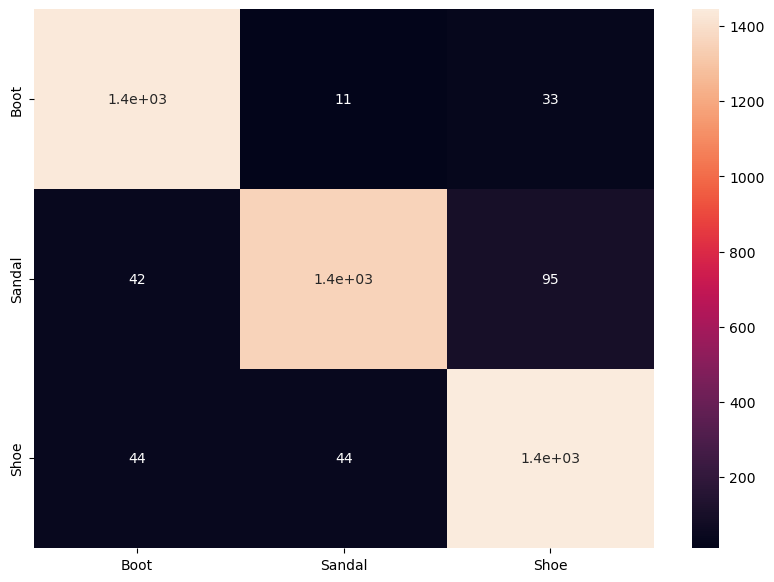

In [35]:
cm_CNN = np.zeros((3,3))
for images, labels in test_dataset.take(-1):
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    y_pred = model_CNN.predict(numpy_images,verbose = 0)
    pred = y_pred.argmax(axis=1)
    true = numpy_labels.argmax(axis=1)
    cm_CNN += confusion_matrix(true, pred)
print(cm_CNN)

df_cm = pd.DataFrame(cm_CNN, index = ["Boot", "Sandal", "Shoe"],
                  columns = ["Boot", "Sandal", "Shoe"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

### Network's Parameters

In [36]:
model_CNN.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 46, 46, 32)        896       
                                                                 
 dropout_7 (Dropout)         (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 21, 21, 32)        9248      
                                                                 
 conv2d_26 (Conv2D)          (None, 19, 19, 256)       73984     
                                                      

### Tensorboard

In [47]:
%tensorboard --logdir log_CNN/fit

به طور میانگین برای اجراهای مختلف، دقت شبکه ی کانولوشنی روی دادگان تست، نسبت به شبکه ی چند لایه ی پرسپترونی حدودا 4 تا 5 درصد بیشتر می باشد، در حالی که تعداد پارامترهای دو شبکه تقریبا برابر است و این موضوع بیانگر قدرت شبکه ی کانولوشنی در این مسئله می باشد. همچنین شبکه کانولوشنی زودتر همگرا می گردد.

# CNN with Block Dropout

### CNN Structure with Block Dropout

In [38]:
model_CNN_d=keras.models.Sequential()
model_CNN_d.add(keras.layers.Rescaling(1. / 255))
model_CNN_d.add(keras.layers.Conv2D(32,(3,3), activation='relu'))
model_CNN_d.add(keras_cv.layers.DropBlock2D(0.2,block_size=10))
model_CNN_d.add(keras.layers.MaxPooling2D(2,2))
model_CNN_d.add(keras.layers.Conv2D(32,(3,3), activation='relu'))
model_CNN_d.add(keras.layers.Conv2D(256,(3,3), activation='relu'))
model_CNN_d.add(keras_cv.layers.DropBlock2D(0.2,block_size=10))
model_CNN_d.add(keras.layers.MaxPooling2D(2,2))
model_CNN_d.add(keras.layers.Conv2D(256,(5,5), activation='relu'))
model_CNN_d.add(keras.layers.MaxPooling2D(2,2))
model_CNN_d.add(keras.layers.Flatten())
model_CNN_d.add(keras.layers.Dense(64, activation='relu'))
model_CNN_d.add(keras.layers.Dense(3, activation='softmax'))

### Train the Network

In [39]:
metrics = ['categorical_accuracy', 'Recall', 'Precision']
model_CNN_d.compile(optimizer = keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics = metrics)


filepath_CNN_d = 'My_Best_CNN_d_Model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath_CNN_d, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model_CNN_d.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, callbacks=[checkpoint])

Epoch 1/30
93/93 [==============================] - ETA: 0s - loss: 0.7563 - categorical_accuracy: 0.6321 - recall: 0.5050 - precision: 0.7216
Epoch 1: val_loss improved from inf to 0.47600, saving model to My_Best_CNN_d_Model.hdf5
93/93 [==============================] - 59s 615ms/step - loss: 0.7563 - categorical_accuracy: 0.6321 - recall: 0.5050 - precision: 0.7216 - val_loss: 0.4760 - val_categorical_accuracy: 0.8019 - val_recall: 0.7612 - val_precision: 0.8262
Epoch 2/30
93/93 [==============================] - ETA: 0s - loss: 0.4183 - categorical_accuracy: 0.8276 - recall: 0.8128 - precision: 0.8408
Epoch 2: val_loss improved from 0.47600 to 0.32861, saving model to My_Best_CNN_d_Model.hdf5
93/93 [==============================] - 60s 641ms/step - loss: 0.4183 - categorical_accuracy: 0.8276 - recall: 0.8128 - precision: 0.8408 - val_loss: 0.3286 - val_categorical_accuracy: 0.8810 - val_recall: 0.8511 - val_precision: 0.9012
Epoch 3/30
93/93 [==============================] - ETA:

### Metrics for Trained CNN Network with Block Dropout on Test Dataset

In [40]:
model_CNN_d = keras.models.load_model(filepath_CNN_d)
score = model_CNN_d.evaluate(test_dataset,verbose=0)
print("For Test Dataset, we have:")
print(f"Loss: {score[0]}")
print(f"Accuracy: {score[1]}")
print(f"Recall: {score[2]}")
print(f"Precision: {score[3]}")

For Test Dataset, we have:
Loss: 0.1652664691209793
Accuracy: 0.9553729891777039
Recall: 0.9527087211608887
Precision: 0.9563182592391968


### Confusion Matrix

[[1439.   26.   17.]
 [  22. 1429.   41.]
 [  29.   64. 1437.]]


<AxesSubplot:>

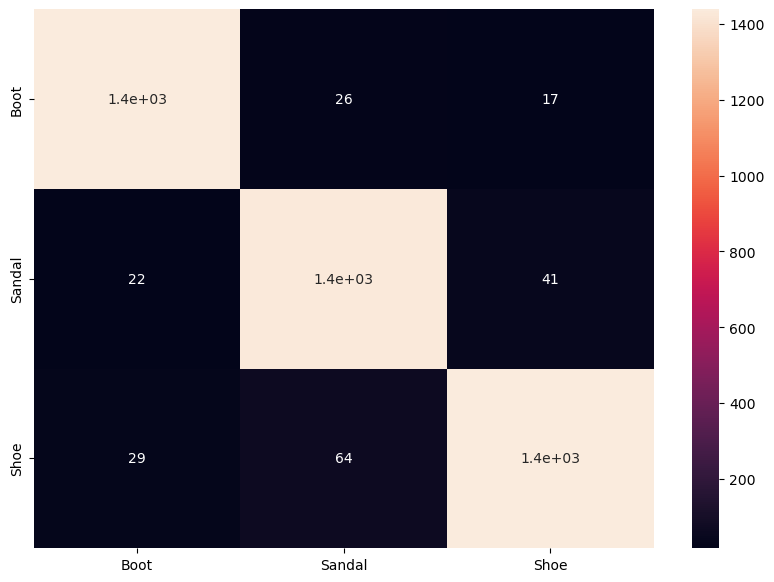

In [41]:
cm_CNN_d = np.zeros((3,3))
for images, labels in test_dataset.take(-1):
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    y_pred = model_CNN_d.predict(numpy_images,verbose = 0)
    pred = y_pred.argmax(axis=1)
    true = numpy_labels.argmax(axis=1)
    cm_CNN_d += confusion_matrix(true, pred)
print(cm_CNN_d)

df_cm = pd.DataFrame(cm_CNN_d, index = ["Boot", "Sandal", "Shoe"],
                  columns = ["Boot", "Sandal", "Shoe"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

در یک شبکه ی کانولوشنی که ویژگی ها با یکدیگر کرولیشن داشته باشند، حتی در صورت استفاده از دراپ اوت می تواند منجر به اورفیت شدن شبکه بشود. بنابراین در این موارد می توان از دراپ اوت بلوکی استفاده نمود که در آن یک بلوک را دراپ اوت می کندو بنابراین ویژگی هایی که با هم کرولیشن دارند، همزمان حذف یا نگه داشته می شوند. از این دراپ اوت برای رگولاریزاسیون در شبکه های کانولوشنی استفاده میشود که از اورفیت  شدن شبکه جلوگیری می نماید و همان گونه که در نتایج مشخص است، استفاده ازاین نوع دراپ اوت موجب افزایش دقت تست از 94 به 95.5 درصد شده است. 

# Factorization

### CNN with Factorization

In [42]:
model_CNN_f=keras.models.Sequential()
model_CNN_f.add(keras.layers.Rescaling(1. / 255))
model_CNN_f.add(keras.layers.Conv2D(32,(3,1), activation='relu'))
model_CNN_f.add(keras.layers.Conv2D(32,(1,3), activation='relu'))
model_CNN_f.add(keras.layers.Dropout(0.2))
model_CNN_f.add(keras.layers.MaxPooling2D(2,2))
model_CNN_f.add(keras.layers.Conv2D(32,(3,1), activation='relu'))
model_CNN_f.add(keras.layers.Conv2D(32,(1,3), activation='relu'))
model_CNN_f.add(keras.layers.Conv2D(256,(3,1), activation='relu'))
model_CNN_f.add(keras.layers.Conv2D(256,(1,3), activation='relu'))
model_CNN_f.add(keras.layers.Dropout(0.2))
model_CNN_f.add(keras.layers.MaxPooling2D(2,2))
model_CNN_f.add(keras.layers.Conv2D(256,(5,1), activation='relu'))
model_CNN_f.add(keras.layers.Conv2D(256,(1,5), activation='relu'))
model_CNN_f.add(keras.layers.MaxPooling2D(2,2))
model_CNN_f.add(keras.layers.Flatten())
model_CNN_f.add(keras.layers.Dense(64, activation='relu'))
model_CNN_f.add(keras.layers.Dense(3, activation='softmax'))

In [43]:
metrics = ['categorical_accuracy', 'Recall', 'Precision']
model_CNN_f.compile(optimizer = keras.optimizers.Adam(lr), loss='categorical_crossentropy', metrics = metrics)


filepath_CNN_f = 'My_Best_CNN_f_Model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath_CNN_f, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model_CNN_f.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, callbacks=[checkpoint])

Epoch 1/30
93/93 [==============================] - ETA: 0s - loss: 0.6786 - categorical_accuracy: 0.6757 - recall: 0.5618 - precision: 0.7562
Epoch 1: val_loss improved from inf to 0.39588, saving model to My_Best_CNN_f_Model.hdf5
93/93 [==============================] - 69s 731ms/step - loss: 0.6786 - categorical_accuracy: 0.6757 - recall: 0.5618 - precision: 0.7562 - val_loss: 0.3959 - val_categorical_accuracy: 0.8572 - val_recall: 0.8331 - val_precision: 0.8738
Epoch 2/30
93/93 [==============================] - ETA: 0s - loss: 0.3458 - categorical_accuracy: 0.8726 - recall: 0.8609 - precision: 0.8838
Epoch 2: val_loss improved from 0.39588 to 0.30327, saving model to My_Best_CNN_f_Model.hdf5
93/93 [==============================] - 70s 750ms/step - loss: 0.3458 - categorical_accuracy: 0.8726 - recall: 0.8609 - precision: 0.8838 - val_loss: 0.3033 - val_categorical_accuracy: 0.8993 - val_recall: 0.8781 - val_precision: 0.9168
Epoch 3/30
93/93 [==============================] - ETA:

### Metrics for Trained CNN Network with Factorization on Test Dataset

In [44]:
model_CNN_f = keras.models.load_model(filepath_CNN_f)
score = model_CNN_f.evaluate(test_dataset,verbose=0)
print("For Test Dataset, we have:")
print(f"Loss: {score[0]}")
print(f"Accuracy: {score[1]}")
print(f"Recall: {score[2]}")
print(f"Precision: {score[3]}")

For Test Dataset, we have:
Loss: 0.16451497375965118
Accuracy: 0.949600338935852
Recall: 0.9460479617118835
Precision: 0.9523916244506836


### Confusion Matrix

[[1427.   22.   35.]
 [  23. 1402.   60.]
 [  27.   66. 1442.]]


<AxesSubplot:>

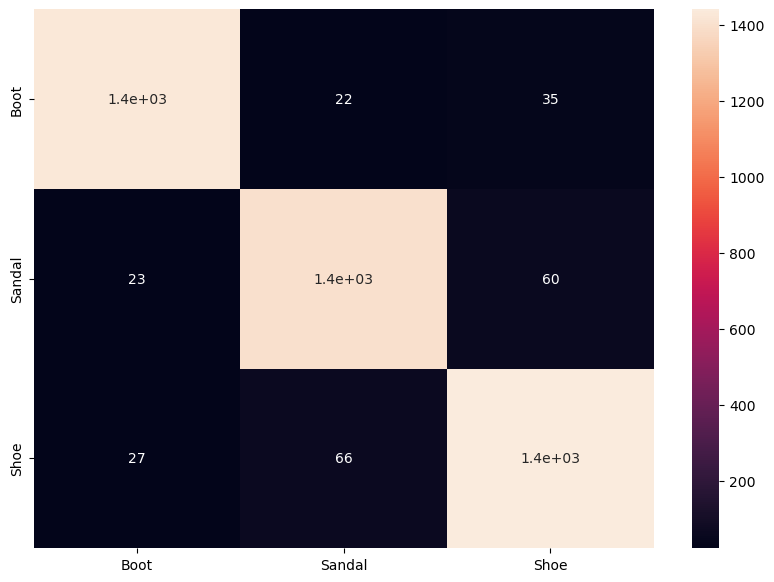

In [45]:
cm_CNN_f = np.zeros((3,3))
for images, labels in test_dataset.take(-1):
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    y_pred = model_CNN_f.predict(numpy_images,verbose = 0)
    pred = y_pred.argmax(axis=1)
    true = numpy_labels.argmax(axis=1)
    cm_CNN_f += confusion_matrix(true, pred)
print(cm_CNN_f)

df_cm = pd.DataFrame(cm_CNN_f, index = ["Boot", "Sandal", "Shoe"],
                  columns = ["Boot", "Sandal", "Shoe"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

### Network's Parameters

In [46]:
model_CNN_f.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 48, 48, 3)         0         
                                                                 
 conv2d_32 (Conv2D)          (None, 46, 48, 32)        320       
                                                                 
 conv2d_33 (Conv2D)          (None, 46, 46, 32)        3104      
                                                                 
 dropout_9 (Dropout)         (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 21, 23, 32)        3104      
                                                      

در حالت فاکتوریزیشن برای شبکه کانولوشنی، تعداد پارامترها تقریبا نصف شد (از حدود یک میلیون و هشتصد هزار به حدود نهصد هزار کاهش پیدا کرد)، اما دقت روی داده ی تست تغییر قابل توجهی نداشت. عملا با این کار هم سایز مدل کوچک تر شد و هم زمان آموزش مدل کوتاه تر شد و در عوض دقت تست می تواند در حد ناچیزی کاهش پیدا کند که در مجموع مطلوب است.بنابراین استفاده از این روش می تواند موجب کاهش زمان آموزش و کوچک تر شدن مدل شود، درحالی که دقت کاهش قابل توجهی نداشته باشد.